In [48]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [49]:
data = pd.read_csv("imdb_movies.csv")
data.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


In [51]:
data["genre"].isnull().value_counts()

genre
False    10093
True        85
Name: count, dtype: int64

In [52]:
unlabeled_data = data[data["genre"].isna()]
unlabeled_data.shape

(85, 12)

In [53]:
labelled_data = data.drop(index= unlabeled_data.index)
labelled_data["genre"].info()

<class 'pandas.core.series.Series'>
Index: 10093 entries, 0 to 10177
Series name: genre
Non-Null Count  Dtype 
--------------  ----- 
10093 non-null  object
dtypes: object(1)
memory usage: 157.7+ KB


In [54]:
# labelled_data["genre"] = labelled_data["genre"].str.split(",")
# labelled_data = labelled_data.explode("genre")
# labelled_data = labelled_data.sample(frac=1, random_state=42).reset_index(drop=True)
# labelled_data = labelled_data.drop(index = labelled_data[labelled_data["genre"].isna()].index)
# labelled_data.shape

In [55]:
def preprocess(x):
    x = re.sub(r"[^\w\s]"," ",x)
    x = x.lower()
    words = word_tokenize(x)
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    return " ".join(words)

In [56]:
labelled_data["overview"] = labelled_data["overview"].apply(preprocess)
labelled_data["genre"] = labelled_data["genre"].apply(preprocess)

In [57]:
x = labelled_data["overview"]
y = labelled_data["genre"]
y.unique()

array(['drama action', 'science fiction adventure action',
       'animation adventure family fantasy comedy', ...,
       'adventure comedy family science fiction action',
       'mystery thriller comedy',
       'action adventure science fiction thriller horror'], dtype=object)

In [58]:
tfid = TfidfVectorizer(
    ngram_range=(1,2),
    analyzer="word",
    max_features=50000,sublinear_tf=True, strip_accents="unicode", max_df=0.90, min_df=2
)

In [59]:
x_transformed = tfid.fit_transform(x)
x_transformed.shape

(10093, 37476)

In [60]:
x_train,x_test,y_train,y_test = train_test_split(x_transformed,y,test_size=0.3,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((7065, 37476), (3028, 37476), (7065,), (3028,))

In [61]:
# from sklearn.svm import SVC

# svc = SVC(kernel="rbf",max_iter=-1,random_state=42,tol=1e-5,gamma="scale",C=1,shrinking=True,)
# svc.fit(x_train,y_train)

# y_pred = svc.predict(x_test)
# accuracy_score(y_test,y_pred)

In [62]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=8,random_state=42,n_init=10)
labels = km.fit_predict(x_train)

In [63]:
from sklearn.metrics import silhouette_score
silhouette_score(x_train,labels)

np.float64(0.007464617981796085)

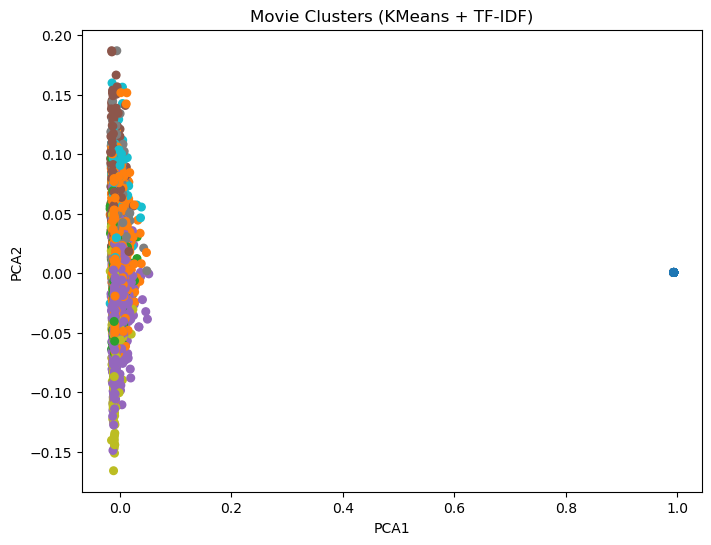

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for plotting
X_reduced = PCA(n_components=2, random_state=42).fit_transform(x_train.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap="tab10", s=30)
plt.title("Movie Clusters (KMeans + TF-IDF)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()